In [1]:
import pandas as pd
import numpy as np
import glob
from tqdm.notebook import tqdm

def printShape(df, cols=[], msg=''):
    
    print(df.shape, end='  ')
    for col in cols:
        print(col, df[col].nunique(), end='  ')
    print(msg)
    
    return df

DIR = '../data/study_2_data'
LARGEFILE = '../data/large'

In [2]:
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib

cm = 1/2.54  # centimeters in inches
font = {'size': 7}
matplotlib.rc('font', **font)

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

matplotlib.rcParams['grid.linewidth'] = 0.5
matplotlib.rcParams['axes.linewidth'] = 0.5

def set_size(w,h, ax=None):
    """ w, h: width, height in inches """
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)

# Load data

## Load paper info

In [3]:
%%time
paperJournal = (
    pd.read_csv(f'{LARGEFILE}/PaperJournal.csv', usecols=['PaperID','JournalID'])
    .drop_duplicates(subset=['PaperID'])
    .pipe(printShape) # 208261724
)

(208261724, 2)  
CPU times: user 1min 48s, sys: 4.22 s, total: 1min 52s
Wall time: 3min 3s


In [4]:
%%time
paperYear = (
    pd.read_csv(f'{LARGEFILE}/PaperYear.csv', usecols=['PaperID','Year'])
    .pipe(printShape) # 257748845
)

(257748845, 2)  
CPU times: user 35.5 s, sys: 2.5 s, total: 38.1 s
Wall time: 1min 16s


In [5]:
%%time
paperOACount = (
    pd.read_csv(f'{LARGEFILE}/PaperCitingOACount.csv')
    .query('is_oa==True')
    .drop(['is_oa'], axis=1)
    .rename(columns={'CitingPaperID':'PaperID'})

    .groupby('PaperID')['count'].sum().reset_index()
    .pipe(printShape, cols=['PaperID'])
) # 71458673

(71458673, 2)  PaperID 71458673  
CPU times: user 1min 28s, sys: 4.08 s, total: 1min 32s
Wall time: 3min 7s


In [6]:
%%time
totalRef = pd.read_csv(f'{LARGEFILE}/PaperReferencesCount.csv').pipe(printShape) # 87419190

(87419190, 2)  
CPU times: user 11.6 s, sys: 3.16 s, total: 14.8 s
Wall time: 29.5 s


In [7]:
%%time
paperPaywalledPercent = (
    paperOACount
    .merge(totalRef, on='PaperID', how='right')
    .fillna({'count': 0})
    .assign(Percent=lambda df: 1- (df['count'] / df.ReferencesCount))
    # "count" is number of references that goes to OA papers

    .merge(paperJournal, on='PaperID')
    .assign(Percent_within=lambda df: df.groupby('JournalID')['Percent'].transform(lambda x: x - np.mean(x)))
    .pipe(printShape) # 78821844

    .drop(['JournalID'], axis=1)
)

(78821844, 6)  
CPU times: user 2min 52s, sys: 11.5 s, total: 3min 3s
Wall time: 6min 15s


# Compute embeddings

First train a doc2vec model using paper abstracts from OpenAlex (code is `../src/doc2vec.py`).

Then, compute embeddings of papers using `../src/ComputePaperVecDoc2vec.py`.

Finally, compute the diameter of referenced papers using `../src/refListDiameter.py`

# Analysis

In [8]:
%%time
aggDistance = pd.read_csv(
    f'{LARGEFILE}/CitationsPaperDistanceAggregated_30percent_all_100dim.csv',
    usecols=['CitingPaper','Diameter_var']
)

CPU times: user 10.8 s, sys: 503 ms, total: 11.3 s
Wall time: 23.5 s


In [9]:
%%time
distance50dim = pd.read_csv(
    f'{LARGEFILE}/CitationsPaperDistanceAggregated_30percent_all.csv',
    usecols=['CitingPaper','Diameter_var']
)

CPU times: user 10.7 s, sys: 1.08 s, total: 11.8 s
Wall time: 26.4 s


In [10]:
def getPaywallDistance(aggDistance, paperPaywalledPercent=paperPaywalledPercent):
    
    return (
        paperPaywalledPercent.rename(columns={'PaperID':'CitingPaper'})
        .merge(aggDistance, on='CitingPaper')
        .pipe(printShape)

        .assign(Percentile_20=lambda df: pd.qcut(df['Percent'], 20, labels=False))
    )   

In [11]:
%%time
paywallDistance = getPaywallDistance(aggDistance)
paywallDistance50dim = getPaywallDistance(distance50dim)
# 43733176

(43733176, 6)  
(43733176, 6)  
CPU times: user 1min 10s, sys: 7.65 s, total: 1min 17s
Wall time: 2min 41s


In [12]:
import scipy
from matplotlib.ticker import AutoMinorLocator

def getCI(data, confidence=0.95):
    
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    
    return m, h


def plotCI(df, x, col, width=5, ax=None, lo=0, hi=0.14, left=-0.5, right=1.5):
    
    if ax is None: ax = plt.gca()
    
    color = '#e41a1c'
        
    means = df[col].apply(lambda x: x[0])
    errs = df[col].apply(lambda x: x[1])
    
    errs = df[col].apply(lambda x: x[1])
    
    plotline, caplines, barlinecols = ax.errorbar(
        x=x, y=means, yerr=errs, fmt = ' ', marker='_', ms=width+1, ecolor=(0, 0, 0, 0.2),
        elinewidth=width, capsize=0, color=color
    )

    plt.setp(barlinecols[0], capstyle="round", color=color, alpha=0.2)


def plotPointPlot(df, x, y, x_original, ax=None):
    
    if ax is None:
        ax = plt.gca()

    # df[y] = df[y].astype(int)
    
    toPlot = df.groupby(x).agg({y: getCI}).reset_index()
        
    plotCI(toPlot, x=toPlot[x], col=y, ax=ax, width=4)
    
    labelsDf = (
        df.groupby(x).agg({x_original:['min', 'max']}).reset_index()
        .assign(
            Label=lambda df: df.apply(
                lambda row: f"[{row[x_original, 'min']*100:.0f}%, {row[x_original, 'max']*100:.0f}%)", axis=1
            )
        )
    )
    
    xticksshow=[_ for _ in range(2, 20, 7)]
    xtickslabel=labelsDf.loc[xticksshow, 'Label'].values

    ax.set_xticks(xticksshow)
    ax.set_xticklabels(xtickslabel)
    
    ax.minorticks_on()
    ax.xaxis.set_minor_locator(AutoMinorLocator(7))
    ax.tick_params('x', length=4, width=1, which='major')
    ax.tick_params(axis='y', which='minor', length=0)
    
    ax.set_xlabel('')
    ax.set_ylabel('')
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    return ax, labelsDf, toPlot

CPU times: user 2.72 s, sys: 354 ms, total: 3.07 s
Wall time: 11.3 s


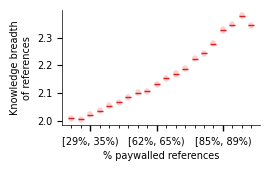

In [13]:
%%time
plt.figure(figsize=(6.5*cm, 3.8*cm))

ax, binsDf, yValues = plotPointPlot(paywallDistance, 'Percentile_20', 'Diameter_var', 'Percent', ax=None)
ax.set_xlabel('% paywalled references')
ax.set_ylabel('Knowledge breadth\nof references')

plt.savefig('../figures/Knowledge_breadth_all.pdf', bbox_inches = 'tight', pad_inches = 0)

CPU times: user 2.6 s, sys: 228 ms, total: 2.82 s
Wall time: 5.74 s


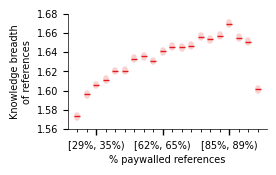

In [14]:
%%time
plt.figure(figsize=(6.5*cm, 3.8*cm))

ax, binsDf, yValues = plotPointPlot(paywallDistance50dim, 'Percentile_20', 'Diameter_var', 'Percent', ax=None)
ax.set_xlabel('% paywalled references')
ax.set_ylabel('Knowledge breadth\nof references')

ax.set_ylim(1.56, 1.68)
ax.set_yticks([1.56, 1.58, 1.60, 1.62, 1.64, 1.66, 1.68])

plt.savefig('../figures/Knowledge_breadth_all_50dim.pdf', bbox_inches = 'tight', pad_inches = 0)

In [15]:
binsDf

Percentile_20   Percent                  Label
                       min       max             
0              0  0.000000  0.210526    [0%, 21%)
1              1  0.210674  0.291667   [21%, 29%)
2              2  0.291740  0.352941   [29%, 35%)
3              3  0.352995  0.405063   [35%, 41%)
4              4  0.405099  0.454545   [41%, 45%)
5              5  0.454681  0.500000   [45%, 50%)
6              6  0.500603  0.538462   [50%, 54%)
7              7  0.538593  0.578947   [54%, 58%)
8              8  0.579082  0.615385   [58%, 62%)
9              9  0.615445  0.652174   [62%, 65%)
10            10  0.652185  0.688889   [65%, 69%)
11            11  0.688946  0.723077   [69%, 72%)
12            12  0.723112  0.756757   [72%, 76%)
13            13  0.756794  0.789474   [76%, 79%)
14            14  0.789572  0.821429   [79%, 82%)
15            15  0.821472  0.853081   [82%, 85%)
16            16  0.853093  0.886364   [85%, 89%)
17            17  0.886398  0.920000   [89%, 92%)
18            18  0.920036  0.956522   [92%, 96%)
19            19  0.956567  1.000000  [96%, 100%)